In [2]:
library(tidyverse)
library(sva)
library(edgeR)

In [20]:
pca_plot <- function(df, batch_info, title, path) {
  pca <- prcomp(t(na.omit(df)))
  # Plot PCA
  pca_df <-
    pca$x %>%
    as.data.frame() %>%
    rownames_to_column("sample_id") %>% 
    left_join(batch_info,  by = "sample_id") 
  # add % of explained variance
  var_expl <- pca$sdev^2 / sum(pca$sdev^2)
  names(var_expl) <- paste0("PC", 1:length(var_expl))
  # Add the label for the specific point
  pca_plot <- pca_df %>%
    ggplot(aes(PC1, PC2)) +
    geom_point(aes(col=lab, shape=Lum), size=2) +
    theme_classic() +
    labs(title = title,
         x = glue::glue("PC1 [{round(var_expl['PC1']*100, 2)}%]"),
         y = glue::glue("PC2 [{round(var_expl['PC2']*100, 2)}%]"))

  if(path != "") {ggsave(path, pca_plot)}
  return(pca_plot)
}

In [11]:
labs_list = c('GSE129508', 'GSE149276', 'GSE58135')  
data_matrix <- NULL
meta_info <- NULL

for (name in labs_list) {
  file_name_prefix <- paste0('/home/yuliya/repos/cosybio/removeBatch/test_data/counts/')

  if(is.null(data_matrix)){
    data_matrix <- read.csv(paste0(file_name_prefix, 'raw/', name, '.counts.tsv'), check.names = FALSE, sep="\t") 
    meta_info <- read.csv(paste0(file_name_prefix, name, '.sample_info.tsv'), check.names = FALSE, sep="\t")
    # add new column with name
    meta_info$lab <- name
  } else {
    data_matrix <- full_join(data_matrix, 
                       read.csv(paste0(file_name_prefix, 'raw/', name, '.counts.tsv'), check.names = FALSE, sep="\t"),
                       by = "gene_id")
    meta_info <- rbind(meta_info, read.csv(paste0(file_name_prefix, name, '.sample_info.tsv'), check.names = FALSE, sep="\t") %>% mutate(lab = name))
  }
}

rownames(meta_info) <- meta_info$sample_id
meta_info <- meta_info %>% mutate(is_LumA = as.factor(is_LumA), lab = as.factor(lab))
data_matrix <- data_matrix %>% column_to_rownames("gene_id")
#data_matrix <- data_matrix[, rownames(meta_info)]

meta_plots <- meta_info

In [12]:
dim(data_matrix)
head(data_matrix)

[1] 35238   132

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
A1BG,363,732,650,379,912,98,376,88,506,184,⋯,1914,425,1051,1034,2422,1147,634,2498,1179,760
A1CF,5,16,0,7,15,0,3,4,2,10,⋯,110,9,33,38,205,76,26,83,26,41
A2M,19059,16821,15554,14844,31897,10656,15895,32102,26985,20846,⋯,5048,11582,16842,19400,1912,4247,48515,18468,2978,256904
A2ML1,52,31,11,44,101,64,121,62,51,1300,⋯,1218,4266,219,141,248,933,9083,793,121,291
A2MP1,1,0,0,0,1,0,0,0,1,0,⋯,39,8,34,74,19,14,21,19,6,67
A3GALT2,1,0,2,1,7,0,1,1,3,2,⋯,43,9,6,11,23,63,9,34,6,12


In [13]:
dim(meta_info)
head(meta_info)

[1] 132   5

,sample_id,Lum,Basal,is_LumA,lab
,<chr>,<int>,<int>,<fct>,<fct>
GSM3714577,GSM3714577,1,0,1,GSE129508
GSM3714579,GSM3714579,1,0,0,GSE129508
GSM3714581,GSM3714581,1,0,0,GSE129508
GSM3714585,GSM3714585,1,0,1,GSE129508
GSM3714587,GSM3714587,1,0,1,GSE129508
GSM3714589,GSM3714589,1,0,0,GSE129508


# on raw

,sample_id,Lum,Basal,is_LumA,lab
,<chr>,<int>,<int>,<fct>,<fct>
GSM3714577,GSM3714577,1,0,1,GSE129508
GSM3714579,GSM3714579,1,0,0,GSE129508
GSM3714581,GSM3714581,1,0,0,GSE129508


In [15]:
mod_covariates <- model.matrix(~ Lum, data=meta_info)
batch <- as.numeric(meta_info$lab) - 1

# Run ComBat
batch_corrected_raw <- ComBat(data_matrix, batch=batch, mod=mod_covariates)

Found 6394 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




# on normalized

In [16]:
raw_exprs <- DGEList(data_matrix)

# normalize 
all_groups <- c(group1, group2)
group = as.factor(apply(meta_info[, all_groups], 1, function(x) {
  all_groups[as.logical(x)]
}))
keep_exprs <- filterByExpr(raw_exprs, group=group)

cat(paste0("Genes passed filterByExprs: ",length(keep_exprs[keep_exprs])))
raw_exprs_filtered <- raw_exprs[keep_exprs,, keep.lib.sizes=FALSE]

raw_exprs <- calcNormFactors(raw_exprs_filtered, method = "upperquartile") # TMM

raw_exprs_normalized <- cpm(raw_exprs, log=TRUE)
head(raw_exprs_normalized, 3)

Genes passed filterByExprs: 19861

,GSM3714577,GSM3714579,GSM3714581,GSM3714585,GSM3714587,GSM3714589,GSM3714591,GSM3714595,GSM3714597,GSM3714599,⋯,GSM1401714,GSM1401725,GSM1401692,GSM1401689,GSM1401752,GSM1401719,GSM1401736,GSM1401744,GSM1401681,GSM1401723
A1BG,3.427972,4.6818628,4.394393,4.032185,4.661398,1.935841,3.785306,1.127351,3.705522,2.864899,⋯,6.021296,2.689867,4.4189874,4.475718,5.965890,5.334068,3.044363,5.466796,4.7461815,3.4646067
A1CF,-2.334306,-0.7115367,-4.300637,-1.506405,-1.101217,-4.300637,-2.640736,-2.758910,-3.291839,-1.171689,⋯,1.918648,-2.424217,-0.4722795,-0.206615,2.415998,1.443697,-1.369657,0.602655,-0.6405645,-0.6358548
A2M,9.135644,9.2014082,8.971756,9.319356,9.786829,8.681425,9.181809,9.604483,9.436882,9.678825,⋯,7.419717,7.447174,8.4180041,8.702348,5.625086,7.221321,9.293383,8.351546,6.0813127,11.8589939


In [17]:
mod_covariates <- model.matrix(~ Lum, data=meta_info)
batch <- as.numeric(meta_info$lab) - 1

# Run ComBat
batch_corrected_normalized <- ComBat(raw_exprs_normalized, batch=batch, mod=mod_covariates)

Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




# plots

In [23]:
meta_plots$Lum <- as.factor(meta_plots$Lum)

on raw

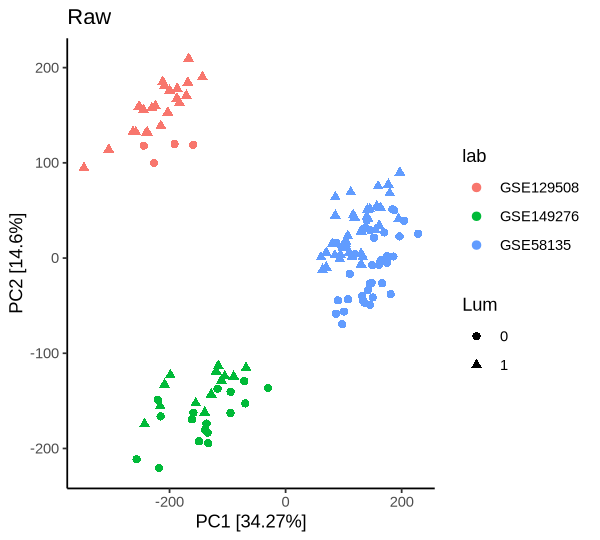

In [24]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5)
pca_plot(log2(data_matrix + 1), meta_plots, "Raw", "")

Warning message in na.omit(df):
“NaNs produced”


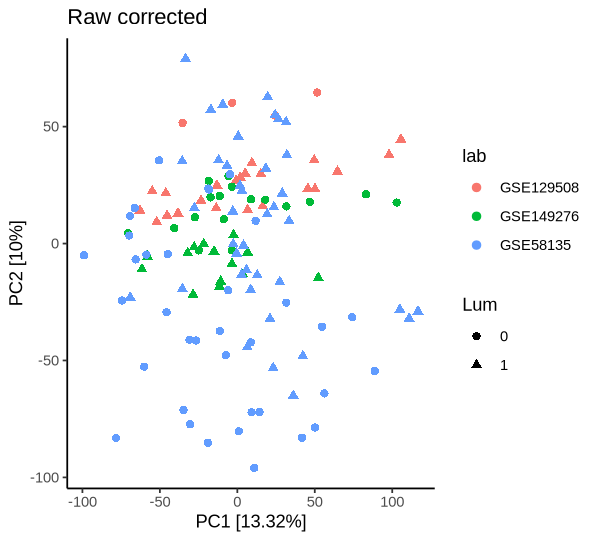

In [25]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5)
pca_plot(log2(batch_corrected_raw + 1), meta_plots, "Raw corrected", "")

on normalized

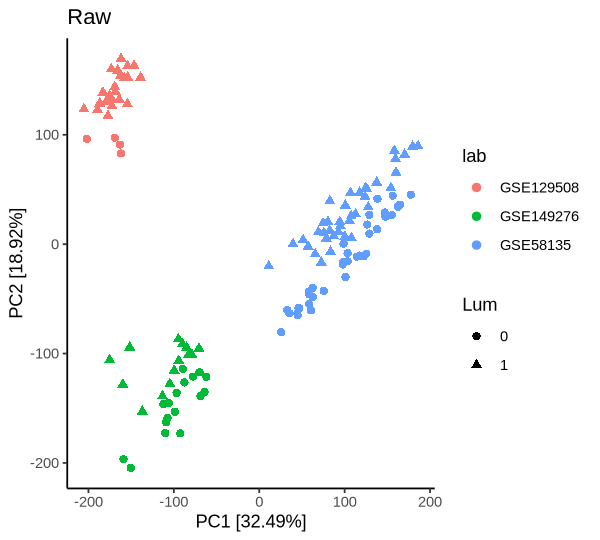

In [26]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5)
pca_plot(raw_exprs_normalized, meta_plots, "Raw normalized", "")

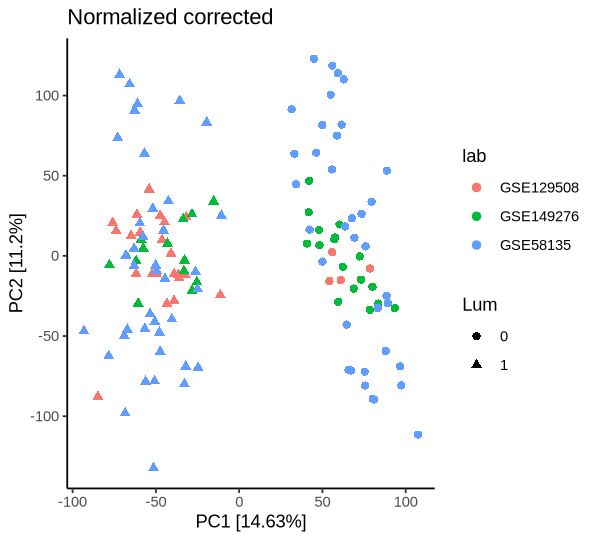

In [28]:
# raw normalized
options(repr.plot.width =  5, repr.plot.height = 4.5)
pca_plot(batch_corrected_normalized, meta_plots, "Normalized corrected", "")

# save to file

In [30]:
# save to file
write.table(batch_corrected_normalized, file = "/home/yuliya/repos/cosybio/removeBatch/test_data/processed_counts/batch_corrected_normalized.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)

In [31]:
# save to file
write.table(raw_exprs_normalized, file = "/home/yuliya/repos/cosybio/removeBatch/test_data/processed_counts/raw_exprs_normalized.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)

In [33]:

# save to file
write.table(data_matrix, file = "/home/yuliya/repos/cosybio/removeBatch/test_data/processed_counts/data_matrix.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)

In [32]:


# save to file
write.table(batch_corrected_raw, file = "/home/yuliya/repos/cosybio/removeBatch/test_data/processed_counts/batch_corrected_raw.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)

In [34]:
# meta
write.table(meta_info, file = "/home/yuliya/repos/cosybio/removeBatch/test_data/processed_counts/meta_info.tsv", sep = "\t", quote = FALSE, row.names = TRUE, col.names = TRUE)